In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [2]:
# Changing plots' parameters (style, ticks, font, color)
sns.set_style('dark', rc={'axes.facecolor': '#e3e6e3',
                          'font.family': 'Montserrat',
                          'font.weight': 400,
                          'text.color': '#1a1f19',
                          'xtick.color': '#242c21',
                          'ytick.color': '#242c21',
                          'patch.force_edgecolor': False})
colors = ['#5a6b5c', '#697e68', '#7a9173', '#8ca57e', '#a0b889', '#b6cc93']
sns.set_palette(sns.color_palette(colors))

**Database Connection & Data Retrieval**

In [3]:
# Local PostgreSQL database connection
conn = psycopg2.connect(
    dbname='postgres',
    user='postgres',
    password='postgres',
    host='localhost',
    port='5432'
)

# Cursor object creation
cur = conn.cursor()

In [4]:
# Fetching the list of schemas in the database
cur.execute('SELECT schema_name FROM information_schema.schemata')

schemas_list = cur.fetchall()

print("Schemas in the database:", schemas_list)

Schemas in the database: [('public',), ('fixfertig',), ('windows_functions',), ('vr_startup',), ('metropolitan',), ('songify',), ('magazine',), ('information_schema',), ('pg_catalog',), ('pg_toast',)]


In [5]:
# Fetching all tables and columns in the 'fixfertig' schema
cur.execute('''
SELECT table_name, column_name 
FROM information_schema.columns 
WHERE table_schema = 'fixfertig'
''')

# Creating dataframe directly from query results and pivot
df_table_column = pd.DataFrame(cur.fetchall(), columns=['table_name', 'column_name'])
df_table_column = df_table_column.pivot(columns='table_name', values='column_name')

# Sorting each column individually, putting NaN values at the bottom
df_table_column = df_table_column.apply(lambda x: pd.Series(sorted(x, key=lambda x: (pd.isna(x), x or ''))))

df_table_column.dropna(how='all', inplace=True)

In [6]:
df_table_column

table_name,inc_customer_list,inc_geolocations,inc_order_items,inc_order_payments,inc_order_reviews_no_emojis,inc_orders,inc_products,inc_sellers_list
0,customer_age,geo_country,freight_value,order_id,order_id,customer_trx_id,product_category_name,country_code
1,customer_city,geo_lat,order_id,payment_installments,review_answer_timestamp,order_approved_at,product_height_cm,seller_city
2,customer_country,geo_lon,order_item_id,payment_sequential,review_comment_message_en,order_delivered_carrier_date,product_id,seller_country
3,customer_country_code,geo_postal_code,price,payment_type,review_comment_title_en,order_delivered_customer_date,product_length_cm,seller_id
4,customer_gender,geolocation_city,product_id,payment_value,review_creation_date,order_estimated_delivery_date,product_weight_gr,seller_name
5,customer_postal_code,NaN,seller_id,NaN,review_id,order_id,product_width_cm,seller_postal_code
6,customer_trx_id,NaN,shipping_limit_date,NaN,review_score,order_purchase_timestamp,NaN,NaN
7,first_order_date,NaN,NaN,NaN,NaN,order_status,NaN,NaN
8,subscribe_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,subscriber_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
conn.rollback()

# Fetching data from the 'inc_products' table (What Delivered & Of What Size and Weight)
cur.execute('SELECT * FROM fixfertig.inc_products')
inc_products_Column_names = [desc[0] for desc in cur.description]
inc_products = pd.DataFrame(cur.fetchall(), columns=inc_products_Column_names)

# Fetching data from the 'inc_orders' table (When Delivered)
cur.execute('SELECT * FROM fixfertig.inc_orders')
inc_orders_Column_names = [desc[0] for desc in cur.description]
inc_orders = pd.DataFrame(cur.fetchall(), columns=inc_orders_Column_names)

# Fetching data from the 'inc_order_items' table (A Joint for "What Delivered" and "When Delivered")
cur.execute('SELECT * FROM fixfertig.inc_order_items')
inc_order_items_Column_names = [desc[0] for desc in cur.description]
inc_order_items = pd.DataFrame(cur.fetchall(), columns=inc_order_items_Column_names)

# Fetching data from the 'inc_order_reviews_no_emojis' table (Customer Satisfaction with the "What" and "When")
cur.execute('SELECT * FROM fixfertig.inc_order_reviews_no_emojis')
inc_order_reviews_Column_names = [desc[0] for desc in cur.description]
inc_order_reviews = pd.DataFrame(cur.fetchall(), columns=inc_order_reviews_Column_names)

**Variables For the Analysis**  
* **`inc_products`**: `product_id`, `product_category_name`, `product_height_cm`, `product_length_cm`, `product_width_cm`, `product_weight_gr`  
* **`inc_orders`**: `order_id`, `order_status`, `order_estimated_delivery_date`, `order_delivered_customer_date`
* **`inc_order_items`**: `order_id`, `product_id`
* **`inc_order_reviews`**: `order_id`, `review_score`

**Methods**  
* **Brunner-Munzel Test (non-parametric)**
    * **Alternative hypothesis**: Delayed delivery leads to lower review scores compared to on-time delivery.
    * **Choice reasoning**: 
        * Ordinal nature of data;
        * Compared to Mann-Whitney U test this test doesn't assume equal variances/distribution shapes—avoids the Behrens-Fisher problem, which can inflate Type I error rates in the Mann-Whitney test under variance inequality;
        * It naturally handles ties (they distort the distribution of ranks); 
        * It's considered a default choice for determining if one variable tends to have higher values than the other.
    * **Test assumptions**:
        * Independence
        * No equal variance/shape distribution assumption
    * **Auxiliary methods**: Effect Size: Pest (represents the probability of superiority) and Cliff's Delta (represents the degree of dominance).
    * **Data tables**: `inc_orders`, `inc_order_reviews`
* **Kruskal-Wallis H Test (non-parametric)**:
    * **Alternative hypotheses**: 
        1. At least one product size group has a different distribution of review scores for delayed deliveries;
        2. At least one product weight group has a different distribution of review scores for delayed deliveries;
        3. At least one product category has a different distribution of review scores for delayed deliveries.
    * **Choice reasoning**: 
        * Ordinal nature of data;
        * Determines whether at least one group tends to have different values than the others (assesses differences in the distribution of ranks), providing required information to validate the hypotheses.
    * **Test assumptions**:
        * Independence 
        * All groups should have the same shape distributions (otherwise assesses stochastic dominance between groups like in the Brunner-Munzel test but not medians)
    * **Auxiliary methods**: Effect size: Adjusted eta-squared (proportion of variance explained in ranks by the group differences).
    * **Data tables**: `inc_orders`, `inc_order_reviews`, `inc_order_items`, `inc_products`

#### **Brunner-Munzel Test**

First, we need to process target variables before testing.

**`inc_orders`** filtering and data check

In [8]:
# Order status checking to determine only needed data
inc_orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [9]:
# Excluding all order statuses except 'delivered'
inc_orders_filtered = inc_orders.query('order_status == "delivered"')

In [10]:
# Data types and records size check
inc_orders_filtered.info(); # types are correct, 96478 delivered orders

<class 'pandas.core.frame.DataFrame'>
Index: 96478 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_trx_id                96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  datetime64[ns]
 4   order_approved_at              96464 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96476 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96478 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


In [11]:
# Duplicate check
inc_orders_filtered.duplicated(subset=['order_id']).sum() # 0 duplicates

0

In [39]:
# Missing values check
inc_orders_filtered.isnull().sum() # 8 null values in `order_delivered_customer_date` column (other columns are not considered due to their irrelevance)

# Instead of investigating the null values, we will drop them due to the large size of the dataset
inc_orders_filtered.dropna(subset=['order_delivered_customer_date'], inplace=True)

# Final check for null values
inc_orders_filtered.isnull().sum()

order_id                          0
customer_trx_id                   0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      1
order_delivered_customer_date     0
order_estimated_delivery_date     0
dtype: int64

---

Merging **`inc_order_reviews`** with **`inc_orders_filtered`** and final data check

In [13]:
# Merging the filtered orders with the reviews
inc_order_reviews_merged = inc_order_reviews.merge(inc_orders_filtered[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date']], on='order_id', how='inner')

In [14]:
# Data types and records check
inc_order_reviews_merged.info() # types are correct, 96352 orders with ratings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96352 entries, 0 to 96351
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   review_id                      96352 non-null  object        
 1   order_id                       96352 non-null  object        
 2   review_score                   96352 non-null  int64         
 3   review_comment_title_en        11181 non-null  object        
 4   review_comment_message_en      39299 non-null  object        
 5   review_creation_date           96352 non-null  datetime64[ns]
 6   review_answer_timestamp        96352 non-null  datetime64[ns]
 7   order_delivered_customer_date  96352 non-null  datetime64[ns]
 8   order_estimated_delivery_date  96352 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(4)
memory usage: 6.6+ MB


In [15]:
# Duplicate check
review_duplicate_orders_sum = inc_order_reviews_merged.duplicated(subset=['order_id']).sum() # 529 times people rated the same order one or more times
                                                                                             # We also know there's only one actual product per order (no multiple items)

# Keeping only the first order with its duplicates to investigate further
review_duplicate_orders = inc_order_reviews_merged[inc_order_reviews_merged.duplicated(subset=['order_id'], keep=0)]

# Displaying how many unique orders have non-identical review score across their duplicates in percentage
duplicate_orders_review_diff = (abs(review_duplicate_orders.groupby('order_id')['review_score'].diff().dropna()) == True).sum() / review_duplicate_orders_sum * 100
print(f"Percentage of unique orders with non-identical review score across their duplicates: {duplicate_orders_review_diff:.2f}%\n")

# Displaying duplicates per unique order in percentage
print("Percentage of duplicates per unique order:")
(review_duplicate_orders.order_id.value_counts() - 1).value_counts(normalize=1) * 100 # '-1' to exclude the first order and leave only the duplicates

Percentage of unique orders with non-identical review score across their duplicates: 16.82%

Percentage of duplicates per unique order:


count
1    99.238095
2     0.761905
Name: proportion, dtype: float64

In [16]:
# Most of the duplicates (~83%) contain the same review score as the first order. 
# In 99% of cases duplicates appear only one time per original order, whereas comments (in the comment variables) can be different.
# –––––––––––––––––––––––––––

# Finally, we keep only reviews with comments by the principle of the most informative feedback and the time invested in it, 
# otherwise (null values in comment variables) we leave the most recent review.

# Create a helper function to identify which rows to keep
def get_best_review(group):
    # Skip processing for groups with only one row (non-duplicates)
    if len(group) == 1:
        return group.iloc[0]
    
    # If any row has both comments not null
    both_comments = group[(group['review_comment_title_en'].notna()) & 
                         (group['review_comment_message_en'].notna())]
    if not both_comments.empty:
        return both_comments.iloc[0]
    
    # If any row has at least one comment not null
    any_comment = group[group['review_comment_title_en'].notna() | 
                       group['review_comment_message_en'].notna()]
    if not any_comment.empty:
        return any_comment.iloc[0]
    
    # If all comments are null, take the most recent
    return group.loc[group['review_creation_date'].idxmax()]

# Apply the filtering logic
inc_order_reviews_filtered = inc_order_reviews_merged.groupby('order_id').apply(get_best_review).reset_index(drop=True)

In [17]:
# Final check for duplicate orders
inc_order_reviews_filtered.duplicated(subset=['order_id']).sum() # 0 duplicates

0

---

**Visualizing Medians, Variability, Outliers and Score Distributions of both Delayed and On-time delivery statuses**
* Median is better for review scores since they’re usually skewed toward high ratings, whereas the mean gets pulled toward the tail, giving a misleading picture. 
* It better represents the "typical" customer experience: "half of customers rated us this score or higher."
* Variability and Ordinal nature of data determine the decision about which test for comparison to use.
    * Mann-Whitney U test vs. Brunner-Munzel test. The latter doesn't assume equal variances/similar shapes as the former.  
    When "Unequal sample sizes + unequal variances + different distribution shapes", Mann-Whitney can give misleading results.
    * Mann-Whitney U test doesn't compare medians/central tendency if distribution shapes are not similar.  
    It also needs corrections for ties in ranking calculations, whereas Brunner-Munzel test handles them seamlessly by adjusting probabilities.

In [18]:
# Create a boolean mask for delayed deliveries
inc_order_reviews_filtered['is_delayed'] = inc_order_reviews_filtered['order_delivered_customer_date'] > inc_order_reviews_filtered['order_estimated_delivery_date']

C:\Users\david\AppData\Local\Temp\ipykernel_11192\575494806.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


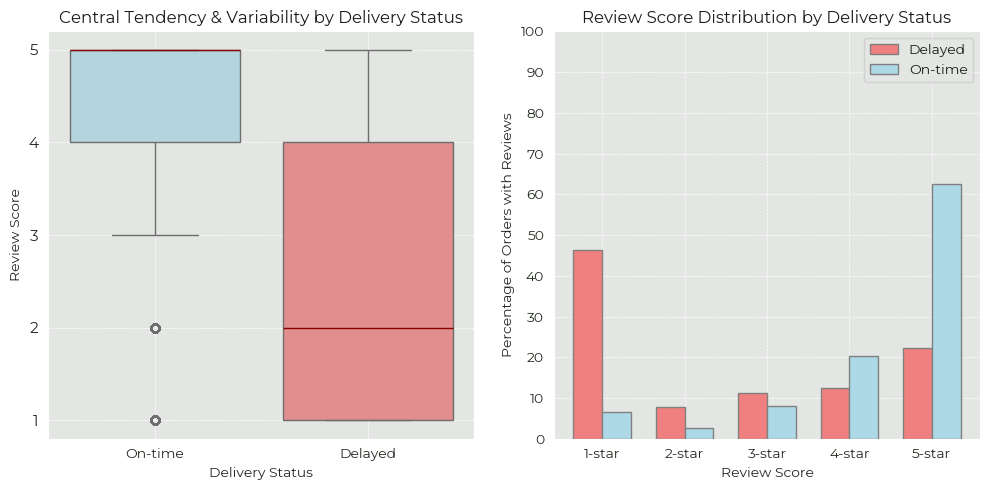

In [19]:
# Color mapping for boxplots
color_map = {'True': 'lightcoral', 'False': 'lightblue'}

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- First subplot: Boxplot ---
sns.boxplot(
    data=inc_order_reviews_filtered, 
    x='is_delayed', 
    y='review_score', 
    palette=color_map,
    medianprops={'color': 'darkred'},
    ax=axes[0]
)

axes[0].set_title('Central Tendency & Variability by Delivery Status', size=12)
axes[0].set_xlabel('Delivery Status')
axes[0].set_ylabel('Review Score')
axes[0].set_xticks([0, 1])
axes[0].set_yticks(range(1, 6), [1, 2, 3, 4, 5], size=11)
axes[0].set_xticklabels(['On-time', 'Delayed'])
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=1)

# --- Second subplot: Barplot ---
labels = ['1-star', '2-star', '3-star', '4-star', '5-star']
delayed = (inc_order_reviews_filtered.query('is_delayed == True').review_score.value_counts(normalize=True) * 100).sort_index().values
ontime = (inc_order_reviews_filtered.query('is_delayed == False').review_score.value_counts(normalize=True) * 100).sort_index().values

x = np.arange(len(labels))
width = 0.35

axes[1].bar(x - width/2, delayed, width, label='Delayed', color='lightcoral', edgecolor='grey')
axes[1].bar(x + width/2, ontime, width, label='On-time', color="lightblue", edgecolor='grey')

axes[1].set_title('Review Score Distribution by Delivery Status', size=12)
axes[1].set_ylabel('Percentage of Orders with Reviews')
axes[1].set_xlabel('Review Score')
axes[1].set_xticks(x)
axes[1].set_yticks(range(0, 110, 10))
axes[1].set_xticklabels(labels)
axes[1].legend()
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=1)

plt.tight_layout(w_pad=2)
plt.show()

* Review scores of products with **on-time delivery** are skewed to the **left**, showing **low variability** while leaning toward **the highest score** (median: 5 | IQR: 4-5).
* Review scores of products with **delayed delivery** are skewed to the **right**, showing **high variability** while leaning toward **the lowest score** (median: 2 | IQR: 1-4).

**Conclusion**: Both groups show distinct distribution shapes and medians, with opposite trends yet some resistance in delivery delays.

---

**Brunner-Munzel Assumptions**
* Observations in both groups must be independent of each other.
* The test works with ordinal or continuous data.
* It doesn't assume any specific distribution.
* It doesn't assume equal group sizes (uses appropriate degrees of freedom calculations).
* It doesn't assume equal variances/distribution shapes.

In [20]:
# Independence Assumption.

# One review is independent of others, because the user's choice to rate a product is unrelated to how others rate different products (only by collective agreement or influence), 
# therefore review scores grouped by delivery status are independent.

Brunner-Munzel Test & Effect Size, 95% CI Calculation

In [21]:
# Getting review scores by delivery status
delayed_scores = inc_order_reviews_filtered[inc_order_reviews_filtered['is_delayed']]['review_score']
ontime_scores = inc_order_reviews_filtered[~inc_order_reviews_filtered['is_delayed']]['review_score']

# Perform test (also known as the Generalized Wilcoxon Test)
#   Answers question "Does one group tend to have higher values than the other?"
#   Null Hypothesis: P(X<Y)+0.5⋅P(X=Y)=0.5 (i.e., neither distribution is stochastically larger than the other).
bm_result = stats.brunnermunzel(delayed_scores, ontime_scores)

def brunner_munzel_effect_size(x, y):
    """
    Calculate Brunner-Munzel effect size (Pest)\n
    Pest (Stochastic Superiority) serves as a rank-based probabilistic effect size that complements the Brunner-Munzel test\n
    
    Ranges from 0 to 1\n
    * 0.5 = no effect (called "stochastic equality") = the probability that Y is greater than X equals the probability that X is greater than Y (accounting for ties).\n
    * p* > 0.5 → values in Y tend to be larger than X\n
    * p* < 0.5 → values in X tend to be larger than Y\n
    """
    nx, ny = len(x), len(y)

    # Compute pooled ranks (handling ties via averaged ranks)
    all_data = np.concatenate([x, y])
    ranks = stats.rankdata(all_data)  # Automatically handles ties
    rank_y = ranks[nx:]  # Ranks for group y
    
    # Calculate Pest using rank-based formula
    mean_rank_y = np.mean(rank_y)
    effect_size = (mean_rank_y - (ny + 1)/2) / nx # Derived from the original effect size (pest) formula P(X<Y)+0.5⋅P(X=Y)

    return round(np.clip(effect_size, 0.0, 1.0), 3)

def cliffs_delta(x, y):
    """
    Calculate Cliff's Delta (δ) from Brunner-Munzel's Pest.\n
    * Directly quantifies dominance (unlike Pest, which is probabilistic).\n
    * More intuitive for audiences familiar with Cohen’s d (both use negative/positive values).\n
    * Unlike Cohen’s d, which relies on mean differences, Cliff’s Delta focuses on rank-based comparisons, making it ideal for ordinal data or cases where assumptions of normality and equal variance don’t hold.\n

    Cliff's Delta ∈ [-1, 1]:
    * δ > 0 → Y tends to dominate X (+0.5 = 0.75 Pest)
    * δ < 0 → X tends to dominate Y (-0.5 = 0.25 Pest)
    * δ ≈ 0 → No dominance (0 = 0.5 Pest = stochastic equality)

    """
    pest = brunner_munzel_effect_size(x, y)
    delta = 2 * pest - 1
    return round(np.clip(delta, -1.0, 1.0), 3) # Ensures δ ∈ [-1, 1]

def effect_bootstrap_ci(x, y, method='pest', n_bootstrap=1000):
    """
    Bootstrap CI for Pest/Cliff's Delta effect size\n
    * p* – an effect size measure in non-parametric tests
    """
    bootstrap_effects = []
    
    # Bootstrap
    for _ in range(n_bootstrap):
        x_boot = np.random.choice(x, size=len(x), replace=True)
        y_boot = np.random.choice(y, size=len(y), replace=True)
        
        if method == 'cliff':
            effect = cliffs_delta(x_boot, y_boot)
        else:
            effect = brunner_munzel_effect_size(x_boot, y_boot)

        bootstrap_effects.append(effect)
    
    # 95% CI
    ci_lower, ci_upper = np.percentile(bootstrap_effects, [2.5, 97.5])

    if method == 'cliff':
        observed_effect = cliffs_delta(x, y)
        return f'p* (cliff\'s delta): {observed_effect}, 95% CI: [{round(ci_lower, 3)}, {round(ci_upper, 3)}]'
    else:
        observed_effect = brunner_munzel_effect_size(x, y)
        return f'p* (pest – probabilistic): {observed_effect}, 95% CI: [{round(ci_lower, 3)}, {round(ci_upper, 3)}]'

print(f"Brunner-Munzel Test:")
print(f"Statistic (W): {bm_result.statistic:.3f}")
print(f"p-value: {bm_result.pvalue:.4f}\n")
print(f"Effect Size:")
print(effect_bootstrap_ci(delayed_scores, ontime_scores, method='cliff'))
print(effect_bootstrap_ci(delayed_scores, ontime_scores, method='pest'))

Brunner-Munzel Test:
Statistic (W): 91.270
p-value: 0.0000

Effect Size:
p* (cliff's delta): 0.554, 95% CI: [0.542, 0.566]
p* (pest – probabilistic): 0.777, 95% CI: [0.771, 0.782]


**Interpretation**:
* **Brunner-Munzel Test p-value**:  
Very strong evidence that one group tends to have higher review scores than the other (reject null hypothesis).
* **Effect size & 95% CI**:  
    Cliff's Delta:  
    * We are 95% confident that on-time deliveries (Y) show strong stochastic dominance over delayed deliveries (X) (δ = 0.554, CI [0.542, 0.566]).
    * The CI excludes 0 (no effect), confirming statistical significance.  

    * Interpretation of δ = 0.554 (large effect):
        * Positive δ indicates on-time deliveries (Y) tend to receive higher ratings than delayed ones (X).
        * Magnitude (δ ≈ 0.55) suggests high practical significance (similar to Cohen’s *d* ≈ 0.5).

    Pest:
    * There's a 78% chance a random on-time review is better than a delayed one.
    * A Pest of ~0.78 implies that switching from delayed to on-time delivery would increase review scores 78% of the time (assuming no other factors).
    * At 78%, there’s still 22% of cases (Y < X) where delayed deliveries get comparable or even high ratings, meaning not every delayed order leads to negative scores.

#### **Kruskal-Wallis H Test**

Preprocessing (merging, consistency/null/duplicate checking, categorizing)

In [22]:
# Merging product characteristics (size, weight, category) with the Reviews and Delivery Status

inc_product_delivery_review = inc_order_reviews_filtered.merge(
    inc_order_items[['order_id', 'product_id']],
    on='order_id',
    how='inner'
).merge(
    inc_products[['product_id', 'product_category_name', 'product_weight_gr', 'product_length_cm', 'product_height_cm', 'product_width_cm']],
    on='product_id',
    how='inner'
)

In [23]:
# Consistency check in the merged dataset
inc_product_delivery_review.info()

# Missing value check
inc_product_delivery_review.isna().sum()

# Duplicate check
# Previous duplicate processing and the 'inner' join ensure no duplicates in the merged dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109361 entries, 0 to 109360
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      109361 non-null  object        
 1   order_id                       109361 non-null  object        
 2   review_score                   109361 non-null  int64         
 3   review_comment_title_en        13082 non-null   object        
 4   review_comment_message_en      45572 non-null   object        
 5   review_creation_date           109361 non-null  datetime64[ns]
 6   review_answer_timestamp        109361 non-null  datetime64[ns]
 7   order_delivered_customer_date  109361 non-null  datetime64[ns]
 8   order_estimated_delivery_date  109361 non-null  datetime64[ns]
 9   is_delayed                     109361 non-null  bool          
 10  product_id                     109361 non-null  object        
 11  

review_id                            0
order_id                             0
review_score                         0
review_comment_title_en          96279
review_comment_message_en        63789
review_creation_date                 0
review_answer_timestamp              0
order_delivered_customer_date        0
order_estimated_delivery_date        0
is_delayed                           0
product_id                           0
product_category_name                0
product_weight_gr                   18
product_length_cm                   18
product_height_cm                   18
product_width_cm                    18
dtype: int64

In [24]:
# We drop missing values in the product dimensions and weight columns to avoid unexpected issues in data processing and calculations.
# This method is acceptable here because of the sufficiency of data for robust analysis (over 100k records).

inc_product_delivery_review.dropna(subset=['product_weight_gr', 'product_length_cm', 'product_height_cm', 'product_width_cm'], inplace=True)

In [25]:
inc_product_delivery_review.sample(5)

,review_id,order_id,review_score,review_comment_title_en,review_comment_message_en,review_creation_date,review_answer_timestamp,order_delivered_customer_date,order_estimated_delivery_date,is_delayed,product_id,product_category_name,product_weight_gr,product_length_cm,product_height_cm,product_width_cm
105429,c480b9cb5301d7935593d9abbe08eb1d,d425c97a9b9fb9a356ef02cd35bd124c,4,None,None,2023-06-20,2023-06-21 10:45:00,2023-06-19 20:47:00,2023-06-21,False,6b75ce117b8fcc75289cb6cbe589de6c,Fixed_Telephony,455.0,36.0,18.0,27.0
99593,2c82326c22543983c9dfc3bd3b0c52c8,a3a09d0a201027720550355df943b598,5,None,I bought several times in the US and received ...,2024-01-27,2024-01-30 05:10:00,2024-01-26 19:04:00,2024-02-14,False,980ecbcc15fe174ec1e5757c4d75b1bf,Agro_Industry_And_Commerce,250.0,17.0,3.0,10.0
42925,34fb44a65a0993a8807dc6bfd62cfb6a,7665a43dfebf16e330953e78ebc5a259,5,*****,None,2024-06-23,2024-06-27 16:56:00,2024-06-22 19:38:00,2024-07-26,False,ad2037645597db38527fe3afbe226af2,Drinks,850.0,22.0,17.0,17.0
2492,34a8f199fdaf98c9657b7352fbfaedd1,90c12c43daa0435fe23b69ff3f76d8ee,5,All very well,"Satisfied, I'm waiting for the 2nd order.",2024-06-30,2024-06-30 14:47:00,2024-06-29 10:28:00,2024-07-19,False,3fbc0ef745950c7932d5f2a446189725,Health_Beauty,350.0,19.0,12.0,13.0
28356,f6ae89c07dfce9b0c4a76758ba0298e2,cbf3df6a869d7cafcbab3096706ec7a7,4,None,None,2023-05-31,2023-06-01 01:18:00,2023-05-30 13:07:00,2023-06-09,False,af51d485dc5255ba2e18b21b550156e6,Luggage_Accessories,22350.0,32.0,74.0,53.0


In [26]:
# Displaying the max and min values of the product dimensions and weight

for column in ['product_weight_gr', 'product_length_cm', 'product_height_cm', 'product_width_cm']:
    print(f"{column} - min: {inc_product_delivery_review[column].min()}, max: {inc_product_delivery_review[column].max()}")

product_weight_gr - min: 0.0, max: 40425.0
product_length_cm - min: 7.0, max: 105.0
product_height_cm - min: 2.0, max: 105.0
product_width_cm - min: 6.0, max: 118.0


In [27]:
# Categorizing products by their dimensions and weight by the standard classification within the company

# Weight categories
inc_product_delivery_review['product_weight_category'] = pd.cut(
    inc_product_delivery_review.product_weight_gr, 
    bins=[0, 500, 5000, 15000, np.inf], 
    labels=['Light', 'Medium', 'Heavy', 'Extra-heavy'], 
    include_lowest=True
    )

# Dimension categories
dimensions = ['length', 'height', 'width']
labels = ['Small', 'Medium', 'Large', 'Extra-large']
bins = [0, 20, 50, 100, np.inf]

for dim in dimensions:
    col_name = f'product_{dim}_cm'
    cat_name = f'product_{dim}_category'
    inc_product_delivery_review[cat_name] = pd.cut(
        inc_product_delivery_review[col_name],
        bins=bins,
        labels=labels,
        include_lowest=True
    )

In [28]:
# Determine max size category based on dimensions, shrinking categories to the largest found in the row ("Small, Small, Medium" = "Medium")

def get_max_dimension_category(row):
    # Return the largest size category found
    if 'Extra-large' in row.values:
        return 'Extra-large'
    elif 'Large' in row.values:
        return 'Large'
    elif 'Medium' in row.values:
        return 'Medium'
    return 'Small'

dim_columns = ['product_length_category', 'product_height_category', 'product_width_category']

inc_product_delivery_review['product_max_dim_categ'] = inc_product_delivery_review[dim_columns].apply(get_max_dimension_category, axis=1)

---

**Visualizing Product Characteristics (Dimensions & Weights)**

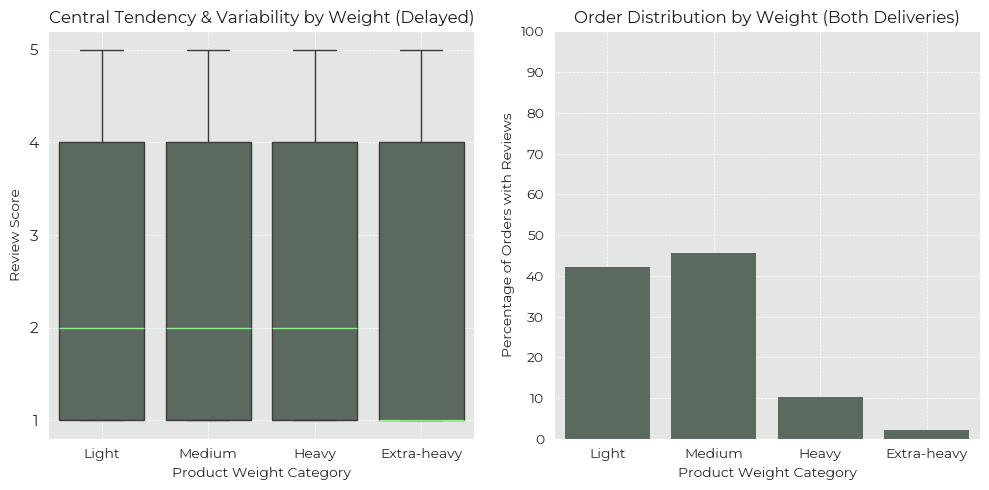

In [29]:
# Plotting weight categories

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot: Review scores by weight (delayed deliveries)
sns.boxplot(
    data=inc_product_delivery_review.query('is_delayed == True'), 
    x='product_weight_category', 
    y='review_score', 
    medianprops={'color': 'lightgreen'},
    ax=axes[0]
)
axes[0].set_title('Central Tendency & Variability by Weight (Delayed)', size=12)
axes[0].set_xlabel('Product Weight Category')
axes[0].set_yticks(range(1, 6), [1, 2, 3, 4, 5], size=11)
axes[0].set_ylabel('Review Score')
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=1)

# Countplot: Order distribution by weight (both deliveries)
sns.countplot(
    data=inc_product_delivery_review,
    x='product_weight_category',
    stat='percent',
    ax=axes[1]
)
axes[1].set_title('Order Distribution by Weight (Both Deliveries)', size=12)
axes[1].set_xlabel('Product Weight Category')
axes[1].set_ylabel('Percentage of Orders with Reviews')
axes[1].set_yticks(range(0, 110, 10))
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=1)

plt.tight_layout(w_pad=2)
plt.show()

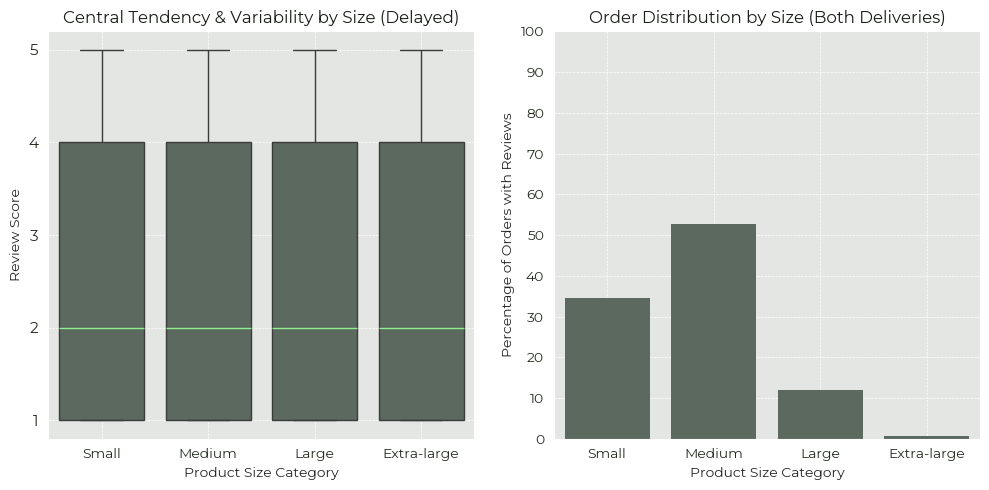

In [30]:
# Plotting size categories

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dim_order = ['Small', 'Medium', 'Large', 'Extra-large']

# Boxplot: Review scores by size (delayed deliveries)
sns.boxplot(
    data=inc_product_delivery_review.query('is_delayed == True'), 
    x='product_max_dim_categ', 
    y='review_score', 
    medianprops={'color': 'lightgreen'},
    order=dim_order,
    ax=axes[0]
)
axes[0].set_title('Central Tendency & Variability by Size (Delayed)', size=12)
axes[0].set_xlabel('Product Size Category')
axes[0].set_ylabel('Review Score')
axes[0].set_yticks(range(1, 6), [1, 2, 3, 4, 5], size=11)
axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=1)

# Countplot: Order distribution by size (both deliveries)
sns.countplot(
    data=inc_product_delivery_review,
    x='product_max_dim_categ',
    stat='percent',
    order=dim_order,
    ax=axes[1]
)
axes[1].set_title('Order Distribution by Size (Both Deliveries)', size=12)
axes[1].set_xlabel('Product Size Category')
axes[1].set_ylabel('Percentage of Orders with Reviews')
axes[1].set_yticks(range(0, 110, 10))
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=1)

plt.tight_layout(w_pad=2)
plt.show()

**Interpretation**: Size-weight score distributions (box plots) remain largely stable, while order distributions (bar plots) highlight significant customer preference differences in the first two categories, with the others showing minimal change.

---

**Visualizing Product Categories**

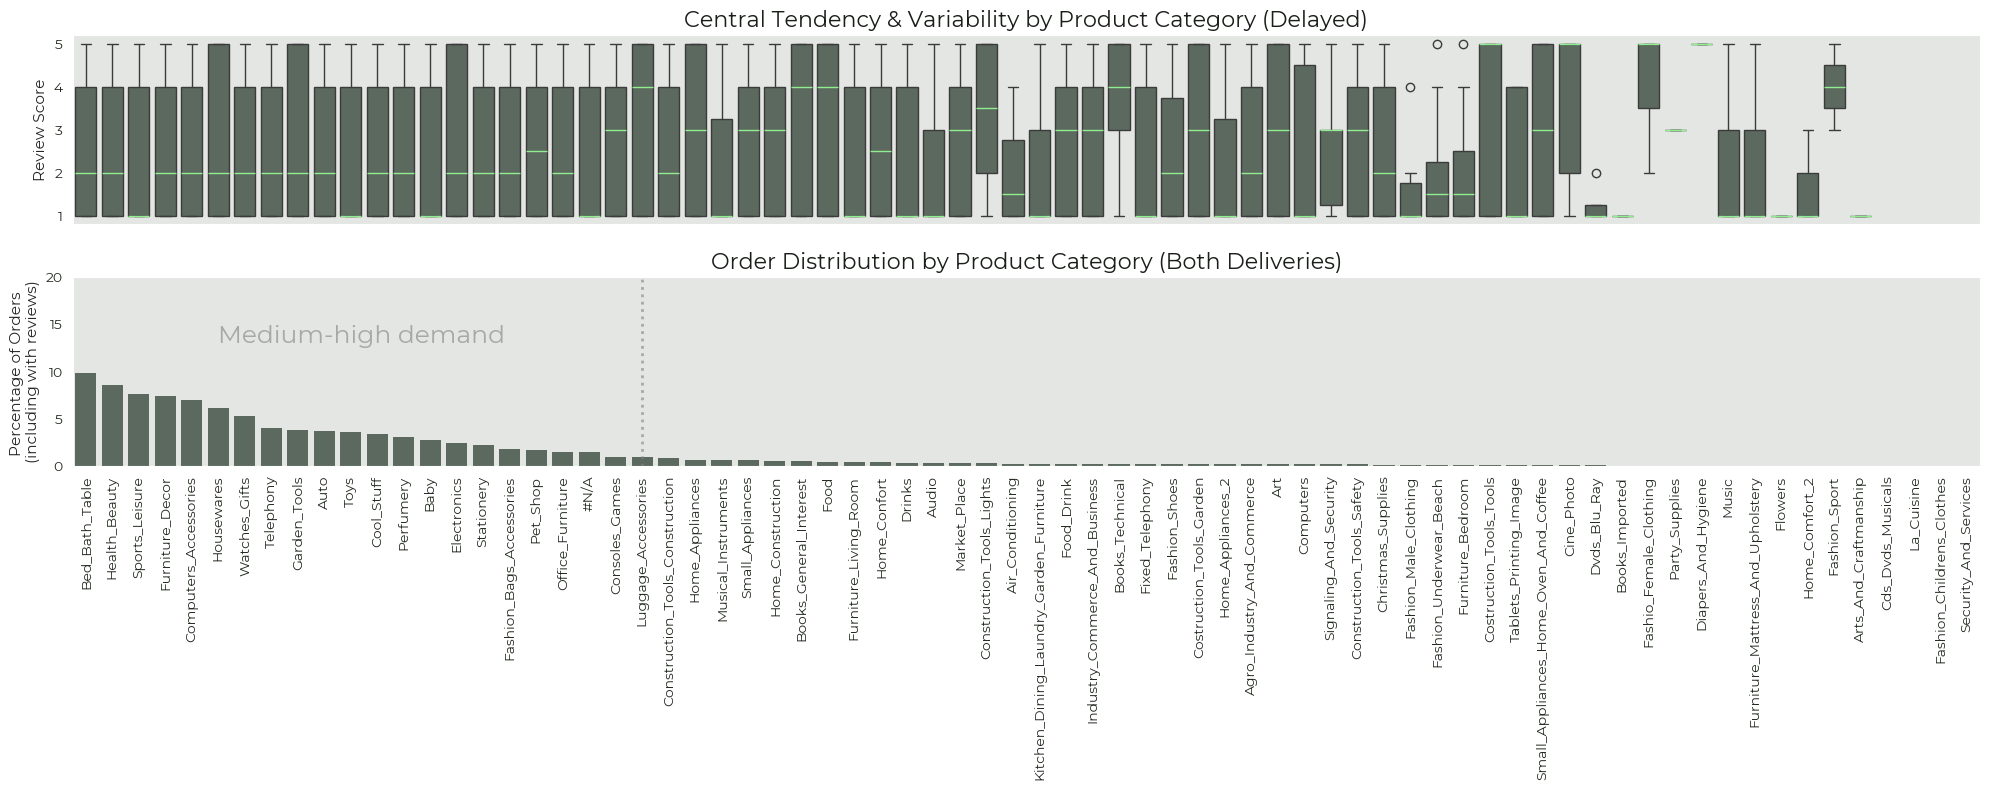

In [32]:
# Merging product category names with all orders (both rated products and beyond)
merged_order_prodcategory = inc_order_items.merge(inc_products[['product_id', 'product_category_name']], on='product_id')

# Sorted categories for smooth ordering
desc_sorted_categories = merged_order_prodcategory.product_category_name.value_counts(normalize=1).sort_values(ascending=False)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 8))

# Boxplot: Review score by product categories (delayed deliveries)
sns.boxplot(
    data=inc_product_delivery_review.query('is_delayed == True'), 
    x='product_category_name', 
    y='review_score', 
    order=desc_sorted_categories.index,
    medianprops={'color': 'lightgreen'},
    ax=axes[0]
)
axes[0].set_title('Central Tendency & Variability by Product Category (Delayed)', size=16)
axes[0].set_xlabel('')
axes[0].set_ylabel('Review Score', size=11)

# Countplot: Order distribution by product category (both deliveries)
sns.countplot(
    data=merged_order_prodcategory,
    x='product_category_name',
    stat='percent',
    ax=axes[1]
)
axes[1].set_title('Order Distribution by Product Category (Both Deliveries)', size=16)
axes[1].set_xlabel('')
axes[1].set_ylabel('Percentage of Orders \n(including with reviews)', size=11)
axes[1].set_yticks(range(0, 25, 5))

axes[1].axvline(x='Luggage_Accessories', color='gray', linestyle='dotted', linewidth=2, alpha=0.6)
axes[1].text(5, 13, "Medium-high demand", fontsize=18, color="gray", alpha=0.6)

plt.xticks(rotation=90)
plt.tight_layout(h_pad=2)
plt.show()

**Interpretation**: Review scores fluctuate across product categories (box plot), possibly reflecting expected customer tolerance for delays. However, categories with fewer orders (bar plot) tend to be more unstable, likely driving these variations.  
**Note**: Low-demand categories (<0.95% of orders) are excluded from testing due to (1) their small sample size (uncertainty) and (2) unnecessary multiple comparisons (false-positives).

---

**Kruskal-Wallis H Test**

Preprocessing

In [33]:
# Groupping review scores by product characteristic categories and delayed delivery status

weight_categories = ["Light", "Medium", "Heavy", "Extra-heavy"]

weight_scores = {
    cat: inc_product_delivery_review.query(
        f'(product_weight_category == "{cat}") & (is_delayed == True)'
        ).review_score.values
    for cat in weight_categories
}

dimension_categories = ['Small', 'Medium', 'Large', 'Extra-large']

dimension_scores = {
    cat: inc_product_delivery_review.query(
        f'(product_max_dim_categ == "{cat}") & (is_delayed == True)'
        ).review_score.values
    for cat in dimension_categories
}

In [34]:
# Keep product categories with sufficient demand (>0.95% of all orders per category)
category_proportion = (inc_product_delivery_review.product_category_name.value_counts(normalize=1)*100).reset_index()
demanding_categories = category_proportion.query('proportion > 0.95').product_category_name.values

prod_categ_scores = {
    cat: inc_product_delivery_review.query(
        f'(product_category_name == "{cat}") & (is_delayed == True)'
        ).review_score.values
    for cat in demanding_categories
}

Test

In [35]:
# Effect size calculation
def eta_squared_kruskal(H_stat, group_data):
    """
    **Adjusted eta-squared (η²) effect size for Kruskal-Wallis test**\n
    Quantifies the proportion of variance explained by the grouping variable, helping to assess the strength of differences between groups.
    * 0 = no variance explained (groups are identical in ranks)
        * Estimation can be slightly negative but should be interpreted as 0, usually in small samples or very weak effects
    * 0.01–0.06 → Small effect
    * 0.07–0.14 → Medium effect
    * \\>0.14 → Large effect\n
    * 1 = all variance explained (perfect separation between groups)\n
    Multiplied by 100%, it estimates the percentage of variance in ranks explained by group differences.\n
        Example: η²=0.12 → "Approximately 12% of the variance in ranks is explained by group differences, suggesting a medium effect."
    ---
    ε² (and ω², omega-squared) is less biased and preferred for more accurate effect size estimation (but less optimistic).\n
    For non-sig. results: Helps diagnose low power/sample size issues (result is inconclusive and potentially a Type II error).
    
    ---
    **Reference** (effect sizes for non-parametric tests):\n
    https://www.researchgate.net/publication/303919832_The_need_to_report_effect_size_estimates_revisited_An_overview_of_some_recommended_measures_of_effect_size
    """
    k = len(group_data) # Total groups
    N = sum(len(values) for values in group_data.values())  # Total sample size
    return f'{((H_stat - k + 1) / (N - k) * 100):.2f}%'

# Weight
kw_stat_w, kw_p_w = stats.kruskal(*weight_scores.values())
print(f"Kruskal-Wallis (Weight): H = {kw_stat_w:.3f}, p = {kw_p_w:.4f}, η² = {eta_squared_kruskal(kw_stat_w, weight_scores)}")

# Dimension
kw_stat_d, kw_p_d = stats.kruskal(*dimension_scores.values())
print(f"Kruskal-Wallis (Dimension): H = {kw_stat_d:.3f}, p = {kw_p_d:.4f}, η² = {eta_squared_kruskal(kw_stat_d, dimension_scores)}")

# Category
kw_stat_c, kw_p_c = stats.kruskal(*prod_categ_scores.values())
print(f"Kruskal-Wallis (Category): H = {kw_stat_c:.3f}, p = {kw_p_c:.4f}, η² = {eta_squared_kruskal(kw_stat_c, prod_categ_scores)}")

Kruskal-Wallis (Weight): H = 3.326, p = 0.3440, η² = 0.00%
Kruskal-Wallis (Dimension): H = 1.456, p = 0.6925, η² = -0.02%
Kruskal-Wallis (Category): H = 29.283, p = 0.1074, η² = 0.11%


Validating results by comparing group means

In [36]:
print("Mean (Weight):")
for key in weight_scores.keys():
    print(f'(size: {len(weight_scores[key])}) {key}: {round(np.mean(weight_scores[key]), 3)}')

Mean (Weight):
(size: 3436) Light: 2.557
(size: 3915) Medium: 2.564
(size: 917) Heavy: 2.467
(size: 251) Extra-heavy: 2.446


In [37]:
print("Mean (Dimension):")
for key in dimension_scores.keys():
    print(f'(size: {len(dimension_scores[key])}) {key}: {round(np.mean(dimension_scores[key]), 3)}')

Mean (Dimension):
(size: 2912) Small: 2.571
(size: 4404) Medium: 2.541
(size: 1109) Large: 2.509
(size: 94) Extra-large: 2.543


In [38]:
print("Mean (Category):")
for key in prod_categ_scores.keys():
    print(f'(size: {len(prod_categ_scores[key])}) {key}: {round(np.mean(prod_categ_scores[key]), 3)}')

Mean (Category):
(size: 893) Bed_Bath_Table: 2.498
(size: 833) Health_Beauty: 2.609
(size: 615) Sports_Leisure: 2.48
(size: 673) Furniture_Decor: 2.559
(size: 582) Computers_Accessories: 2.552
(size: 431) Housewares: 2.694
(size: 473) Watches_Gifts: 2.395
(size: 365) Telephony: 2.622
(size: 334) Garden_Tools: 2.572
(size: 338) Auto: 2.621
(size: 288) Toys: 2.375
(size: 244) Cool_Stuff: 2.471
(size: 243) Perfumery: 2.506
(size: 255) Baby: 2.329
(size: 264) Electronics: 2.742
(size: 196) Stationery: 2.5
(size: 123) Fashion_Bags_Accessories: 2.431
(size: 116) Pet_Shop: 2.647
(size: 146) Office_Furniture: 2.479
(size: 142) #N/A: 2.387
(size: 81) Consoles_Games: 2.654
(size: 57) Luggage_Accessories: 2.982


**Interpretation**:  
* There is insufficient evidence to reject the null hypotheses, confirming that (1) product size and weight do not impact review scores for delayed products, and (2) customers show no tolerance for delays in specific categories.  
* Less then 1% of the variance in ranks was explained by the group differences across all tests conducted, suggesting no effect.  
* The consistent median score for delayed deliveries across the characteristics considered is 2.  